In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Visualization tools
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

In [8]:
train_set = torchvision.datasets.MNIST("./data/", train=True, download=True)
valid_set = torchvision.datasets.MNIST("./data/", train=False, download=True)

100%|██████████| 9.91M/9.91M [00:08<00:00, 1.18MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 102kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.52MB/s]


In [9]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train

In [10]:
valid_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test

In [22]:
x_0, y_0 = train_set[0]

In [23]:
x_0

In [ ]:
print(f"Tipo della X: {type(x_0)}") 
print(f"Valore della Y: {y_0}")
print(f"Tipo della Y: {type(y_0)}")

Tipo della X: <class 'PIL.Image.Image'>
Valore della Y: 5
Tipo della Y: <class 'int'>


<br><br>

---

<br>

### Tensori

In [26]:
trans = transforms.Compose([transforms.ToTensor()])
x_0_tensor = trans(x_0)

/Users/chris/.local/share/virtualenvs/Notes-5FvvYq58/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [31]:
print(f"Tipo di dati nel tensore: {x_0_tensor.dtype}")

Tipo di dati nel tensore: torch.float32


Rircordiamo che il casting a tensore normalizza il valore di minimo e di massimo:

In [33]:
print(f"Max value -> {x_0_tensor.max()}")
print(f"Min value -> {x_0_tensor.min()}")

Max value -> 1.0
Min value -> 0.0


<br>

Possiamo anche confermare che le dimensioni rispettino quello che ci aspettiamo e che seguano la formula:  

$$ C \times H \times W $$

Ogni immagine dell'MNIST è 28x28 (784 pixel totali) ed è in bianco è nero (1 solo canale di colore), quindi ci aspettiamo $\rightarrow$ 1x 28 x 28 

In [34]:
x_0_tensor.size()

torch.Size([1, 28, 28])

Stampa di un tensore per intero (guardare bene le dimensioni che confermano la parte sopra del notebook):    

In [35]:
x_0_tensor

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [36]:
x_0_tensor.device

device(type='cpu')

I tensori sono normalmente processati dalla GPU, in applicazioni veri vogliamo che questi vengano processati da GPU e in particolare da CUDA.  
Possiamo usare il metodo
```python
x_0_gpu = x_0_tensor.cuda()
```

per spostare la computazione su GPU, ma se il sistema non dispone di una GPU fallirà.  

<br>

Per questo motivo si preferisce definire un `device` e poi associare i tensori ad esso, se la GPU esiste allora funzionerà con la GPU, altrimenti userà la CPU garantendo portabilità.  


In [39]:
x_0_tensor.to(device).device

device(type='cpu')

Possiamo convertire i numeri del tensore a un'immagine PIL con la seguente funzione

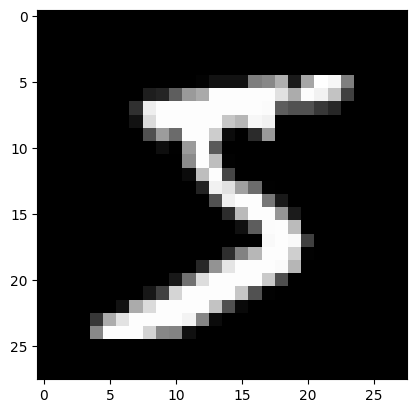

In [37]:
image = F.to_pil_image(x_0_tensor)
plt.imshow(image, cmap='gray')

<br><br>


--- 

## Preparazione dei dati per il training



Precedentemente avevamo creato una variabile `trans` per convertire un immagine in un tensore.  

Le **Transform** sono un gruppo di funzione torch che venono applicate per trasformare il dataset.  

La `Compose` combina una lista di transform!  

In [ ]:
trans = transforms.Compose([transforms.ToTensor()])

Possiamo applicare la lista di transform che vogliamo eseguire **all'intero dataset**.  
Il modo per farlo è il seguente:

In [41]:
train_set.transform = trans 
valid_set.transform = trans 

<br>

Il **`DataLoader`** definisce come vengono estratti gli elementi del nostro train set per allenare il modello.  
La letteratura ci dice che usare batch piccoli è conveniente rispetto a fornire l'intero dataset, e in molti casi usare un batch size di 32 o 64 è ideale.  

In [ ]:
batch_size = 32 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

<br><br>

---


## Creazione del modello 

È il momento di creare la *Rete Neurale*.    
Dobbiamo definire i layer (che sono i responsabili di eseguire una operazioni matematiche sui dati prima di passarli al layer successivo).  

Creeremo:
1. `Flatten` layer $\rightarrow$ convertire il tensore n-dimensionale in un vettore monodimensionale 
2. Input layer $\rightarrow$ il primo layer di neuroni 
3. Hidden layer $\rightarrow$ un layer di neuroni 'nascosto' tra quello di input e output 
4. Output layer $\rightarrow$ ultimo set di neuroni che fanno la previsione finale del modello usando il lavoro svolto da tutti gli altri neuroni e layer.  

In [ ]:
layers = []

### Appiattire le immagini: 

Le nostre immagini sono strutture a 3 dimensioni, in particolare (1 x 28 x 28), vogliamo appiattirle a una singola dimensione.  

Questa operazione non è banale e bisogna stare molto attenti alla sintassi! sotto si riporta un esempio di errore classico, successivamente si vedrà la solzione.  

In [46]:
test_matrix = torch.tensor([
    [1,2,3],
    [4,5,6],
    [7,8,9]
])
test_matrix.size()

torch.Size([3, 3])

In [49]:
nn.Flatten()(test_matrix)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

Notiamo che non è cambiato niente, le dimensioni sono rimaste invariate!  

La funzione `nn.Flatten()` ha una regola fissa di default: **Non tocca mai la prima dimensione, appiattisce tutto il resto**.  

Questo perchè la prima dimensione è riservata al **Batch size**.  
Se ho 10 foto voglio che restino 10 foto distinte, non voglio unire tutto in un unico pure di pixel (che non permette di distinguere foto diverse).  

Quello che succede in questo caso è:
- Passiamo a flatten un tensore di dimensioni (3,3)
- Flatten guarda la prima dimensione e pensa che gli stiamo passando 3 esempi diversi (batch size).  
- Guarda il resto (l'altro 3) e appiattisce i dati successivi, in questo caso abbiamo un array di 3 elementi, che di natura è già piatto!
- *Risultato*: Flatten non fa nulla, restituisce il tensore (3,3).  

<br>

**SOLUZIONE**:   
Impachettiamo il nostro tensore in una dimensione extra per fare in modo che la Flatten funzioni correttamente!  

Usiamo lo slicing per aggiungere una dimensione, equivale a racchiudere la nostra struttura dentro delle parentesi quadrate `[]`.   

In [50]:
batch_test_matrix = test_matrix[None,:]
batch_test_matrix

tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])

In [51]:
nn.Flatten()(batch_test_matrix)

tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]])

Ora funziona!  

Nota: **l'ordine è fondamentale**, la dimensione extra va messa davanti a tutte le altre, in quanto è quella che definsce il batch size e permette alla rete di distinguere esempi diversi e di appiattire il resto dei dati.  
Se la mettessimo in fondo causerebbe errori!   

```python
nn.Flatten()(test_matrix[:,None]) // sarebbe errore 
```


<br>

Ora che il nostro layer di flatten funziona, lo possiamo aggiungere alla lista di layer!  


In [54]:
layers = [
    nn.Flatten()
]

layers 

[Flatten(start_dim=1, end_dim=-1)]

In [55]:
input_size = 1 * 28 * 28 

In [58]:
n_classes = 10 

layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),
    nn.ReLU(),
    nn.Linear(512,512),
    nn.ReLU(),
    nn.Linear(512,n_classes) #output
]

In [59]:
model = nn.Sequential(*layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

In [60]:
model = torch.compile(model)

---

In [61]:
loss = nn.CrossEntropyLoss()
opt = Adam(model.parameters())

In [63]:
train_N = len(train_loader.dataset)
valid_N = len(valid_loader.dataset)

def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N 

In [ ]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        opt.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        opt.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [65]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [76]:
epochs = 10

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0


NameError: name 'optimizer' is not defined